# Inference on Predictive and Causal Effects in High-Dimensional Nonlinear Models

## Impact of 401(k) on Financial Wealth

As a practical illustration of the methods developed in this lecture, we consider estimation of the effect of 401(k) eligibility and participation on accumulated assets. 401(k) plans are pension accounts sponsored by employers. The key problem in determining the effect of participation in 401(k) plans on accumulated assets is saver heterogeneity coupled with the fact that the decision to enroll in a 401(k) is non-random. It is generally recognized that some people have a higher preference for saving than others. It also seems likely that those individuals with high unobserved preference for saving would be most likely to choose to participate in tax-advantaged retirement savings plans and would tend to have otherwise high amounts of accumulated assets. The presence of unobserved savings preferences with these properties then implies that conventional estimates that do not account for saver heterogeneity and endogeneity of participation will be biased upward, tending to overstate the savings effects of 401(k) participation.

One can argue that eligibility for enrolling in a 401(k) plan in this data can be taken as exogenous after conditioning on a few observables of which the most important for their argument is income. The basic idea is that, at least around the time 401(k)’s initially became available, people were unlikely to be basing their employment decisions on whether an employer offered a 401(k) but would instead focus on income and other aspects of the job.

### Data

The data set comes from the `hdm` R package, and is loaded in Julia using the `RData` package

In [1]:
# it is good practice to create a project environment to avoid dependency conflicts
# using Pkg
# Pkg.activate("env")

  Activating project at `c:\Users\Work\Documents\Personal\Work\classes\CausalAI-Course\labs\julia_notebooks\Lab8\env`


In [2]:
using CSV, DataFrames, Gadfly, MLJ

In [3]:
url = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.csv"
data = CSV.read(download(url), DataFrame);

In [4]:
data[:, :e401] = categorical(data[:, :e401]);
data[:, :p401] = categorical(data[:, :p401]);

In [5]:
describe(data)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,ira,3462.87,0,0.0,100000,0,Int64
2,a401,3990.46,0,0.0,153000,0,Int64
3,hval,63595.9,0,48000.0,300000,0,Int64
4,hmort,30022.5,0,7000.0,150000,0,Int64
5,hequity,33573.4,-40000,10000.0,300000,0,Int64
6,nifa,13928.6,0,1635.0,1430298,0,Int64
7,net_nifa,10414.1,-502302,270.0,1430298,0,Int64
8,tfa,21566.0,0,3325.0,1536798,0,Int64
9,net_tfa,18051.5,-502302,1499.0,1536798,0,Int64


The data consist of 9,915 observations at the household level drawn from the 1991 Survey of Income and Program Participation (SIPP).  All the variables are referred to 1990. We use net financial assets (*net\_tfa*) as the outcome variable, $Y$,  in our analysis. The net financial assets are computed as the sum of IRA balances, 401(k) balances, checking accounts, saving bonds, other interest-earning accounts, other interest-earning assets, stocks, and mutual funds less non mortgage debts. 

Among the $9915$ individuals, $3682$ are eligible to participate in the program. The variable *e401* indicates eligibility and *p401* indicates participation, respectively.

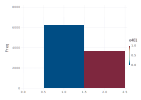

In [6]:
data[!, "n"] .= 1;
e_count = combine(groupby(data, :e401), :n => sum => :Freq);
plot(e_count, color=:e401, y=:Freq, Geom.bar(position=:dodge))

Eligibility is highly associated with financial wealth:

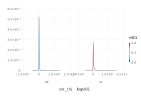

In [7]:
plot(data, x=:net_tfa, xgroup=:e401, color=:e401, Geom.subplot_grid(Geom.density()))

The unconditional APE of e401 is about $19559$

In [8]:
e1 = data[data.e401 .== 0, :];
e2 = data[data.e401 .== 1, :];
round(mean(e2.net_tfa) - mean(e1.net_tfa))

19559.0

Among the $3682$ individuals that are eligible, $2594$ decided to participate in the program. The unconditional APE of p401 is about $27372$

In [9]:
p1 = data[data.p401 .== 0, :];
p2 = data[data.p401 .== 1, :];
round(mean(p2.net_tfa) - mean(p1.net_tfa))

27372.0

As discussed, these estimates are biadsed since they don't account for saver heterogeneity and endogeneity of participation.

## Estimating the ATE of 401(k) Eligibility on Financial Assets

We first look at the treatment effect of e401 on net total financial assets. We give estimates of the ATE and ATT that corresponds to the linear model

$$
Y = D\alpha + f(X)'\beta + \epsilon,
$$

where  $f(X)$  includes indicators of marital status, two-earner status, defined benefit pension status, IRA participation status, and home ownership status, and orthogonal polynomials of degrees 2, 4, 6 and 8 in family size, education, age and income, respectively. The dimensions of  $f(X)$  is 25.

In the first step, we report estimates of the average treatment effect (ATE) of 401(k) eligibility on net financial assets both in the partially linear regression (PLR) model and in the interactive regression model (IRM) allowing for heterogeneous treatment effects.

In [10]:
using StatsBase, StatsModels
# We define the `poly` function as provided by the documentation of the `StatsModels` package:

# syntax: best practice to define a _new_ function
poly(x, n) = x^n

# type of model where syntax applies: here this applies to any model type
const POLY_CONTEXT = Any

# struct for behavior
struct PolyTerm{T,D} <: AbstractTerm
    term::T
    deg::D
end

Base.show(io::IO, p::PolyTerm) = print(io, "poly($(p.term), $(p.deg))")

# for `poly` use at run-time (outside @formula), return a schema-less PolyTerm
poly(t::Symbol, d::Int) = PolyTerm(term(t), term(d))

# for `poly` use inside @formula: create a schemaless PolyTerm and apply_schema
function StatsModels.apply_schema(t::FunctionTerm{typeof(poly)},
                                  sch::StatsModels.Schema,
                                  Mod::Type{<:POLY_CONTEXT})
    apply_schema(PolyTerm(t.args...), sch, Mod)
end

# apply_schema to internal Terms and check for proper types
function StatsModels.apply_schema(t::PolyTerm,
                                  sch::StatsModels.Schema,
                                  Mod::Type{<:POLY_CONTEXT})
    term = apply_schema(t.term, sch, Mod)
    isa(term, ContinuousTerm) ||
        throw(ArgumentError("PolyTerm only works with continuous terms (got $term)"))
    isa(t.deg, ConstantTerm) ||
        throw(ArgumentError("PolyTerm degree must be a number (got $t.deg)"))
    PolyTerm(term, t.deg.n)
end

function StatsModels.modelcols(p::PolyTerm, d::NamedTuple)
    col = modelcols(p.term, d)
    reduce(hcat, [col.^n for n in 1:p.deg])
end

# the basic terms contained within a PolyTerm (for schema extraction)
StatsModels.terms(p::PolyTerm) = terms(p.term)
# names variables from the data that a PolyTerm relies on
StatsModels.termvars(p::PolyTerm) = StatsModels.termvars(p.term)
# number of columns in the matrix this term produces
StatsModels.width(p::PolyTerm) = p.deg

StatsBase.coefnames(p::PolyTerm) = coefnames(p.term) .* "^" .* string.(1:p.deg)

# output


In [11]:
#Constructing the Data
coerce!(data, :net_tfa => MLJ.Continuous, :p401 => Multiclass, :e401 => Multiclass)
y, X = unpack(data, ==(:net_tfa))
d, X = unpack(X, ==(:p401))
z, X = unpack(X, ==(:e401))
select!(X, Not([:a401, :tw, :tfa, :tfa_he, :hval, :hmort, :hequity, :nifa, :net_nifa, :net_n401, :ira, :dum91, :icat, :ecat, :zhat, :i1, :i2, :i3, :i4, :i5, :i6, :i7, :a1, :a2, :a3, :a4, :a5, :n]))
formula_flex = @formula(0 ~ + poly(age, 6) + poly(inc, 8) + poly(educ, 4) + poly(fsize, 2) + male + marr + twoearn + db + pira + hown);
formula_flex = apply_schema(formula_flex, StatsModels.schema(X));
_, X = modelcols(formula_flex, X)
X = DataFrame(X, coefnames(formula_flex)[2])
size(X, 2)

26

In [12]:
coerce!(X, Count => MLJ.Continuous)
first(X, 5) |> pretty

┌────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬─────────────┬─────────────┬─────────────┬─────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┐
│ age^1      │ age^2      │ age^3      │ age^4      │ age^5      │ age^6      │ inc^1      │ inc^2      │ inc^3      │ inc^4      │ inc^5       │ inc^6       │ inc^7       │ inc^8       │ educ^1     │ educ^2     │ educ^3     │ educ^4     │ fsize^1    │ fsize^2    │ male       │ marr       │ twoearn    │ db         │ pira       │ hown       │
│ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ Float64     │ Float64     │ Float64     │ Float64     │ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ Float64

<small>Note: The polynomials for income present an integer overflow problem. This is also the case in Chernozhukov et al.'s original example notebook</small>

# Instrumental Variables: Effect of 401k Participation on Financial Assets

## Double ML IV under Partial Linearity

Now, we consider estimation of average treatment effects of participation in 401k, i.e. `p401`, with the binary instrument being eligibility in 401k, i.e. `e401`. As before, $Y$ denotes the outcome `net_tfa`, and $X$ is the vector of covariates. We consider a partially linear structural equation model:
\begin{align*}
Y &:= g_Y(\epsilon_Y) D + f_Y(A, X, \epsilon_Y)\\
D &:= f_D(Z, X, A, \epsilon_D)\\
Z &:= f_Z(X, \epsilon_Z)\\
A &: = f_A(X, \epsilon_A)\\
X &:=  \epsilon_X
\end{align*}

Under this structural equation model, the average treatment effect:
\begin{align}
\alpha = E[Y(1) - Y(0)]
\end{align}
can be identified by the moment restriction:
\begin{align}
E[(\tilde{Y} - \alpha \tilde{D}) \tilde{Z}] = 0
\end{align}
where for any variable $V$, we denote with $\tilde{V} = V - E[V|X]$.

In [13]:
LassoCVRegressor = @load LassoCVRegressor pkg=MLJScikitLearnInterface
modely = Standardizer() |> LassoCVRegressor(max_iter=10000)
modeld = Standardizer() |> LassoCVRegressor(max_iter=10000)
modelz = Standardizer() |> LassoCVRegressor(max_iter=10000);

[ Info: For silent loading, specify `verbosity=0`. 


import MLJScikitLearnInterface ✔


In [14]:
resy = y .- MLJ.predict(machine(modely, X, y) |> MLJ.fit!, X)
resd = float(d) .- MLJ.predict(machine(modeld, X, float(d)) |> MLJ.fit!, X)
resz = float(z) .- MLJ.predict(machine(modelz, X, float(z)) |> MLJ.fit!, X);

[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:lasso_cv_regressor, …).
[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:lasso_cv_regressor, …).
[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:lasso_cv_regressor, …).


In [15]:
mean(resy .* resz) / mean(resd .* resz)

12957.248747102714

Recall if we want to do inference, we need to either use the theoretically driven penalty parameter for Lasso or perform cross-fitting.

### DML with Non-Linear ML Models and Cross-fitting

In [16]:
function training_sample_append(cv_split, test_sample_index)
        training_indices = []
        for vector in cv_split[Not(test_sample_index)]
                training_indices = [training_indices; vector]
        end
        return training_indices, cv_split[test_sample_index]
end

function dml_iv(X, z, d, y, modely, modeld, modelz, nfolds, args...; classifier=false)
        nobser = length(y)
        cv = [partition(eachindex(y), fill(1/nfolds, nfolds-1)..., shuffle = true)...]
        machine_y = machine(modely, X, y)
        machine_d = machine(modeld, X, d)
        machine_z = machine(modelz, X, z)
        y_hat = zeros(nobser)
        d_hat = zeros(nobser)
        z_hat = zeros(nobser)
        for fold in 1:nfolds
                training_fold, test_fold = training_sample_append(cv, fold)
                y_hat[test_fold] = MLJ.predict(fit!(machine_y, rows = training_fold), X[test_fold, :])
                if classifier
                        d_hat[test_fold] = broadcast(pdf, MLJ.predict(fit!(machine_d, rows = training_fold), X[test_fold, :]), 1)
                        z_hat[test_fold] = broadcast(pdf, MLJ.predict(fit!(machine_z, rows = training_fold), X[test_fold, :]), 1)
                else
                        d_hat[test_fold] = MLJ.predict(fit!(machine_d, rows = training_fold), X[test_fold, :])
                        z_hat[test_fold] = MLJ.predict(fit!(machine_z, rows = training_fold), X[test_fold, :])
                end
        end
        if classifier
                d = float(d)
                z = float(z)
        end
        resy = y .- y_hat
        resd = d .- d_hat
        resz = z .- z_hat
        point_estimate = mean(resy .* resz) / mean(resd .* resz)
        epsilon = resy .- point_estimate * resd
        var = mean(epsilon .^ 2 .* resz .^ 2)/mean(resd .* resz) ^ 2
        std_err = sqrt(var/nobser)
        return point_estimate, std_err, y_hat, d_hat, z_hat, resy, resd, resz, epsilon
end


dml_iv (generic function with 1 method)

In [17]:
function summarize(point, stderr, yhat, Dhat, Zhat, resy, resD, resZ, epsilon, X, Z, D, y; name = "")
        return DataFrame(
                model=name,
                estimate = point, stderr = stderr, lower = point - 1.96 * stderr, upper = point + 1.96 * stderr,
                rmse_y = sqrt(mean(resy .^ 2)), rmse_d = sqrt(mean(resD .^ 2)), rmse_z = sqrt(mean(resZ .^ 2)),
                accuracyD = mean(abs.(resD) .< .5), accuracyZ = mean(abs.(resD) .< .5)
        )
end

summarize (generic function with 1 method)

#### Double Lasso with Cross-Fitting

In [18]:
lassoy = Standardizer() |> LassoCVRegressor(max_iter=10000)
lassod = Standardizer() |> LassoCVRegressor(max_iter=10000)
lassoz = Standardizer() |> LassoCVRegressor(max_iter=10000);
result = dml_iv(X, float(z), float(d), y, lassoy, lassod, lassoz, 3);

[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:lasso_cv_regressor, …).
[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:lasso_cv_regressor, …).
[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:lasso_cv_regressor, …).
[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:lasso_cv_regressor, …).
[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:lasso_cv_regre

In [19]:
summary_table = summarize(result..., X, z, d, y, name="double lasso")

Row,model,estimate,stderr,lower,upper,rmse_y,rmse_d,rmse_z,accuracyD,accuracyZ
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,double lasso,14399.1,1937.14,10602.3,18195.9,55737.8,0.414,0.443532,0.747252,0.747252


#### Using a Penalized Logistic Regression for D

Note the default logistic regression uses an  ℓ2  penalty. You can use the  ℓ1  penalty as well, but computation will take longer.

In [20]:
LogisticCVClassifier = @load LogisticCVClassifier pkg=MLJScikitLearnInterface

import MLJScikitLearnInterface ✔


[ Info: For silent loading, specify `verbosity=0`. 


MLJScikitLearnInterface.LogisticCVClassifier

In [21]:
lassoy = Standardizer() |> LassoCVRegressor(max_iter=10000)
lgrd = Standardizer() |> LogisticCVClassifier(max_iter=10000)
lgrz = Standardizer() |> LogisticCVClassifier(max_iter=10000)
result = dml_iv(X, z, d, y, lassoy, lgrd, lgrz, 3, classifier=true)
append!(summary_table, summarize(result..., X, z, d, y, name="lasso/logistic"))

[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:lasso_cv_regressor, …).
[ Info: Training machine(ProbabilisticPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:logistic_cv_classifier, …).
c:\Users\Work\Documents\Personal\Work\classes\CausalAI-Course\labs\julia_notebooks\Lab8\env\.CondaPkg\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[ Info: Training machine(ProbabilisticPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:logistic_cv_classifier, …).
c:\Users\Work\Doc

Row,model,estimate,stderr,lower,upper,rmse_y,rmse_d,rmse_z,accuracyD,accuracyZ
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,double lasso,14399.1,1937.14,10602.3,18195.9,55737.8,0.414,0.443532,0.747252,0.747252
2,lasso/logistic,13035.1,1839.49,9429.71,16640.5,54267.9,0.414284,0.444719,0.748159,0.748159


#### Random Forests

In [22]:
RandomForestClassifier = @load RandomForestClassifier pkg=MLJScikitLearnInterface
RandomForestRegressor = @load RandomForestRegressor pkg=MLJScikitLearnInterface
rfy = Standardizer() |> RandomForestRegressor(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001)
rfd = Standardizer() |> RandomForestClassifier(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001)
rfz = Standardizer() |> RandomForestClassifier(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001);
result = dml_iv(X, z, d, y, rfy, rfd, rfz, 3, classifier=true)
append!(summary_table, summarize(result..., X, z, d, y, name="random forest"))

import MLJScikitLearnInterface ✔
import MLJScikitLearnInterface ✔

[ Info: For silent loading, specify `verbosity=0`. 
[ Info: For silent loading, specify `verbosity=0`. 


[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:random_forest_regressor, …).
[ Info: Training machine(ProbabilisticPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:random_forest_classifier, …).
[ Info: Training machine(ProbabilisticPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:random_forest_classifier, …).
[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:random_forest_regressor, …).
[ Info: Training machine(ProbabilisticPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training m

Row,model,estimate,stderr,lower,upper,rmse_y,rmse_d,rmse_z,accuracyD,accuracyZ
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,double lasso,14399.1,1937.14,10602.3,18195.9,55737.8,0.414,0.443532,0.747252,0.747252
2,lasso/logistic,13035.1,1839.49,9429.71,16640.5,54267.9,0.414284,0.444719,0.748159,0.748159
3,random forest,12440.9,1958.69,8601.83,16279.9,55670.4,0.415183,0.444357,0.744428,0.744428


#### Decision Trees

In [23]:
DecisionTreeRegressor = @load DecisionTreeRegressor pkg=DecisionTree
DecisionTreeClassifier = @load DecisionTreeClassifier pkg=DecisionTree
dtrfy = Standardizer() |> RandomForestRegressor(min_samples_leaf=10)
dtrfd = Standardizer() |> RandomForestClassifier(min_samples_leaf=10)
dtrfz = Standardizer() |> RandomForestClassifier(min_samples_leaf=10);
result = dml_iv(X, z, d, y, dtrfy, dtrfd, dtrfz, 3, classifier=true)
append!(summary_table, summarize(result..., X, z, d, y, name="decision tree"))

import MLJDecisionTreeInterface

[ Info: For silent loading, specify `verbosity=0`. 


 ✔
import MLJDecisionTreeInterface ✔

[ Info: For silent loading, specify `verbosity=0`. 


[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:random_forest_regressor, …).
[ Info: Training machine(ProbabilisticPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:random_forest_classifier, …).
[ Info: Training machine(ProbabilisticPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:random_forest_classifier, …).
[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:random_forest_regressor, …).
[ Info: Training machine(ProbabilisticPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training m

Row,model,estimate,stderr,lower,upper,rmse_y,rmse_d,rmse_z,accuracyD,accuracyZ
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,double lasso,14399.1,1937.14,10602.3,18195.9,55737.8,0.414,0.443532,0.747252,0.747252
2,lasso/logistic,13035.1,1839.49,9429.71,16640.5,54267.9,0.414284,0.444719,0.748159,0.748159
3,random forest,12440.9,1958.69,8601.83,16279.9,55670.4,0.415183,0.444357,0.744428,0.744428
4,decision tree,12535.1,1880.24,8849.82,16220.3,54628.2,0.416584,0.446483,0.74705,0.74705


#### Boosted Trees

In [24]:
GradientBoostingClassifier = @load GradientBoostingClassifier pkg=MLJScikitLearnInterface
GradientBoostingRegressor = @load GradientBoostingRegressor pkg=MLJScikitLearnInterface
gbfy = Standardizer() |> GradientBoostingRegressor(max_depth=2, n_iter_no_change=5)
gbfd = Standardizer() |> GradientBoostingClassifier(max_depth=2, n_iter_no_change=5)
gbfz = Standardizer() |> GradientBoostingClassifier(max_depth=2, n_iter_no_change=5)
result = dml_iv(X, z, d, y, dtrfy, dtrfd, dtrfz, 3, classifier=true)
append!(summary_table, summarize(result..., X, z, d, y, name="boosted forest"))

import MLJScikitLearnInterface ✔


[ Info: For silent loading, specify `verbosity=0`. 
[ Info: For silent loading, specify `verbosity=0`. 


import MLJScikitLearnInterface ✔


[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:random_forest_regressor, …).
[ Info: Training machine(ProbabilisticPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:random_forest_classifier, …).
[ Info: Training machine(ProbabilisticPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:random_forest_classifier, …).
[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:random_forest_regressor, …).
[ Info: Training machine(ProbabilisticPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training m

Row,model,estimate,stderr,lower,upper,rmse_y,rmse_d,rmse_z,accuracyD,accuracyZ
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,double lasso,14399.1,1937.14,10602.3,18195.9,55737.8,0.414,0.443532,0.747252,0.747252
2,lasso/logistic,13035.1,1839.49,9429.71,16640.5,54267.9,0.414284,0.444719,0.748159,0.748159
3,random forest,12440.9,1958.69,8601.83,16279.9,55670.4,0.415183,0.444357,0.744428,0.744428
4,decision tree,12535.1,1880.24,8849.82,16220.3,54628.2,0.416584,0.446483,0.74705,0.74705
5,boosted forest,12512.1,1932.86,8723.71,16300.5,54736.8,0.416107,0.445475,0.741704,0.741704


#### Inference Robust to Weak Identification

In [25]:
using Distributions: cquantile, Chisq
function robust_inference(point, stderr, yhat, Dhat, Zhat, resy, resD, resZ, epsilon; grid = range(0, 20000, 10000), alpha = 0.05)
        nobser = length(yhat)
        threshold = cquantile(Chisq(1), alpha)
        confidence_region = Float64[]
        for test_estimate in grid
                first_moment = (resy - test_estimate * resd) .* resz
                test_statistic = nobser * mean(first_moment) ^ 2 / var(first_moment)
                if test_statistic <= threshold
                        confidence_region = [confidence_region; test_estimate]
                end
        end
        return confidence_region
end

robust_inference (generic function with 1 method)

In [26]:
region = robust_inference(result...)
min(region...), max(region...)

(9158.915891589158, 16441.64416441644)

We find that the robust inference confidence region is almost identical to the normal based inference. We are most probably in the strong instrument regime. We can check the t-statistic for the effect of the instrument on the treatment, to verify that

In [27]:
beta = mean(resd .* resz) / mean(resz .^ 2)
var_beta = mean((resd - beta .* resz) .^ 2 .* resz .^ 2) / mean(resz .^ 2) .^ 2
se_beta = sqrt(var_beta / length(d))
beta/se_beta

87.57647789618264

Since the $t$-statistic is very large, the normal based approximation and confidence intervals should be fine

## Local Average Treatment Effects of 401(k) Participation on Net Financial Assets

## Interactive IV Model (IIVM)

Now, we consider estimation of local average treatment effects (LATE) of participation `p401`, with the binary instrument `e401`. As before, $Y$ denotes the outcome `net_tfa`, and $X$ is the vector of covariates.  Here the structural equation model is:
\begin{align*}
Y &:=  f_Y (D, X, A, \epsilon_Y) \\
D &:=  f_D(Z, X, A, \epsilon_D) \in \{0,1\},  \\
Z  &:=  f_Z(X,\epsilon_Z) \in \{0,1\},  \\
X &:=  \epsilon_X, \quad A = \epsilon_A,
\end{align*}
where $\epsilon$'s are all exogenous and independent,
and
$$
z \mapsto f_D(z , A, X, \epsilon_D) \text{ is weakly increasing (weakly monotone)}.
$$
and $A$ is a vector of unobserved confounders. Note that in our setting monotonicity is satisfied, since participation is only feasible when it is eligible. Thus we have that $D=0$ whenever $Z=0$. Thus it can only be that $f_D(1, A, X, \epsilon_D) \geq 0 = f_D(0, A, X, \epsilon_D)$.

In this case, we can estimate the local average treatment effect (LATE):
$$
\alpha = E[Y(1) - Y(0) | D(1) > D(0)]
$$
This can be identified using the Neyman orthogonal moment equation:
\begin{align}
E\left[g(1, X) - g(0, X) + H(Z) (Y - g(Z, X)) - \alpha \cdot  (m(1, X) - m(0, X) + H(Z) (D - m(Z, X))\right] = 0
\end{align}
where
\begin{align}
g(Z,X) =~& E[Y|Z,X],\\
m(Z,X) =~& E[D|Z,X],\\
H(Z) =~& \frac{Z}{Pr(Z=1|X)} - \frac{1 - Z}{1 - Pr(Z=1|X)}
\end{align}

In [28]:
function dml_iivm(x, z, d, y, modely0, modely1, modeld0, modeld1, modelz, nfolds; trimming = 0.01)
        nobser = length(y)
        cv = [partition(eachindex(y), fill(1/nfolds, nfolds-1)..., shuffle = true)...]
        machine_y0 = machine(modely0, X, y)
        machine_y1 = machine(modely1, X, y)
        machine_d0 = machine(modeld0, X, y)
        machine_d1 = machine(modeld1, X, d)
        machine_z = machine(modelz, X, z)
        y0_hat = zeros(nobser)
        y1_hat = zeros(nobser)
        d0_hat = zeros(nobser)
        d1_hat = zeros(nobser)
        z_hat = zeros(nobser)
        z0_indices = findall(x->x==0, z)
        z1_indices = findall(x->x==1, z)
        
        for fold in 1:nfolds
                training_fold, test_fold = training_sample_append(cv, fold)
                training_fold0 = intersect(training_fold, z0_indices)
                training_fold1 = intersect(training_fold, z1_indices)
                y0_hat[test_fold] = MLJ.predict(fit!(machine_y0, rows = training_fold0), X[test_fold, :])
                y1_hat[test_fold] = MLJ.predict(fit!(machine_y1, rows = training_fold1), X[test_fold, :])
                
                if mean(float(d) .* (z .== 0)) > 0
                        modeld0 = fit!(machine_d0, rows = training_fold0)
                        d0_hat[test_fold] = broadcast(pdf, MLJ.predict(modeld0, X[test_fold, :]), 1)
                end
                
                if mean(float(d) .* (z .== 1)) < 1
                        modeld1 = fit!(machine_d1, rows = training_fold1)
                        d1_hat[test_fold] = broadcast(pdf, MLJ.predict(modeld1, X[test_fold, :]), 1)
                else
                        d0_hat[test_fold .= 1]
                end

                z_hat[test_fold] = broadcast(pdf, MLJ.predict(fit!(machine_z, rows = training_fold), X[test_fold, :]), 1)
        end
        
        d = float(d)
        z = float(z)
        y_hat = y0_hat .* (1 .- z) + y1_hat .* z
        d_hat = d0_hat .* (1 .- z) + d1_hat .* z
        clamp!(z_hat, trimming, 1 - trimming)
        HZ = z ./ z_hat - (1 .- z) ./ (1 .- z_hat)
        doubly_robust_y = y1_hat - y0_hat + (y - y_hat) .* HZ
        doubly_robust_d = d1_hat - d0_hat + (d - d_hat) .* HZ
        point_estimate = mean(doubly_robust_y) / mean(doubly_robust_d)
        neyman_orthogonal_scores = doubly_robust_y - point_estimate * doubly_robust_d
        variance_denominator = mean(doubly_robust_d)
        var = mean(neyman_orthogonal_scores .^ 2) / variance_denominator .^ 2
        std_err = sqrt(var / nobser)
        return point_estimate, std_err, y_hat, d_hat, z_hat, y - y_hat, d - d_hat, z - z_hat, doubly_robust_y, doubly_robust_d
end
                        

dml_iivm (generic function with 1 method)

In [29]:
function summarize(point, stderr, yhat, Dhat, Zhat, resy, resD, resZ, doubly_robust_y, doubly_robust_d, X, Z, D, y; name = "")
        return DataFrame(
                model=name,
                estimate = point, stderr = stderr, lower = point - 1.96 * stderr, upper = point + 1.96 * stderr,
                rmse_y = sqrt(mean(resy .^ 2)), rmse_d = sqrt(mean(resD .^ 2)), rmse_z = sqrt(mean(resZ .^ 2)),
                accuracyD = mean(abs.(resD) .< .5), accuracyZ = mean(abs.(resD) .< .5)
        )
end

summarize (generic function with 2 methods)

In [30]:
lassoy = Standardizer() |> LassoCVRegressor(max_iter=10000)
lgrd = Standardizer() |> LogisticCVClassifier(max_iter=10000)
lgrz = Standardizer() |> LogisticCVClassifier(max_iter=10000)
result = dml_iivm(X, z, d, y, lassoy, lassoy, lgrd, lgrd, lgrz, 3)
summary_table_iivm = summarize(result..., X, z, d, y, name="lasso/logistic")

[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:lasso_cv_regressor, …).
[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:lasso_cv_regressor, …).
[ Info: Training machine(ProbabilisticPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:logistic_cv_classifier, …).
c:\Users\Work\Documents\Personal\Work\classes\CausalAI-Course\labs\julia_notebooks\Lab8\env\.CondaPkg\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[ Info: Training mach

Row,model,estimate,stderr,lower,upper,rmse_y,rmse_d,rmse_z,accuracyD,accuracyZ
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,lasso/logistic,-8381.76,15163.2,-38101.6,21338.1,55377.8,0.277296,0.444595,0.890267,0.890267


<small>Note: the lasso/logistic estimate seems to be very sensitive to the splits generated in the DML algorithm. The point estimate may have values very different from the other learners, but the confidence intervals should still overlap</small>

In [31]:
rfy = Standardizer() |> RandomForestRegressor(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001)
rfd = Standardizer() |> RandomForestClassifier(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001)
rfz = Standardizer() |> RandomForestClassifier(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001);
result = dml_iivm(X, z, d, y, rfy, rfy, rfd, rfd, rfz, 3)
append!(summary_table_iivm, summarize(result..., X, z, d, y, name="random forest"))

[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:random_forest_regressor, …).
[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:random_forest_regressor, …).
[ Info: Training machine(ProbabilisticPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:random_forest_classifier, …).
[ Info: Training machine(ProbabilisticPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:random_forest_classifier, …).
[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training m

Row,model,estimate,stderr,lower,upper,rmse_y,rmse_d,rmse_z,accuracyD,accuracyZ
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,lasso/logistic,-8381.76,15163.2,-38101.6,21338.1,55377.8,0.277296,0.444595,0.890267,0.890267
2,random forest,11012.4,1663.16,7752.59,14272.2,55153.1,0.275083,0.444034,0.888754,0.888754


In [32]:
dtrfy = Standardizer() |> RandomForestRegressor(min_samples_leaf=10)
dtrfd = Standardizer() |> RandomForestClassifier(min_samples_leaf=10)
dtrfz = Standardizer() |> RandomForestClassifier(min_samples_leaf=10)
result = dml_iivm(X, z, d, y, dtrfy, dtrfy, dtrfd, dtrfd, dtrfz, 3)
append!(summary_table_iivm, summarize(result..., X, z, d, y, name="decision trees"))

[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:random_forest_regressor, …).
[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:random_forest_regressor, …).
[ Info: Training machine(ProbabilisticPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:random_forest_classifier, …).
[ Info: Training machine(ProbabilisticPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:random_forest_classifier, …).
[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training m

Row,model,estimate,stderr,lower,upper,rmse_y,rmse_d,rmse_z,accuracyD,accuracyZ
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,lasso/logistic,-8381.76,15163.2,-38101.6,21338.1,55377.8,0.277296,0.444595,0.890267,0.890267
2,random forest,11012.4,1663.16,7752.59,14272.2,55153.1,0.275083,0.444034,0.888754,0.888754
3,decision trees,11056.4,1789.75,7548.48,14564.3,55930.7,0.275807,0.446679,0.889561,0.889561


In [33]:
gbfy = Standardizer() |> GradientBoostingRegressor(max_depth=2, n_iter_no_change=5)
gbfd = Standardizer() |> GradientBoostingClassifier(max_depth=2, n_iter_no_change=5)
gbfz = Standardizer() |> GradientBoostingClassifier(max_depth=2, n_iter_no_change=5)
result = dml_iivm(X, z, d, y, gbfy, gbfy, gbfd, gbfd, dtrfz, 3)
append!(summary_table_iivm, summarize(result..., X, z, d, y, name="boosted trees"))

[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:gradient_boosting_regressor, …).
[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:gradient_boosting_regressor, …).
[ Info: Training machine(ProbabilisticPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:gradient_boosting_classifier, …).
[ Info: Training machine(ProbabilisticPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info: Training machine(:random_forest_classifier, …).
[ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
[ Info: Training machine(:standardizer, …).
[ Info

Row,model,estimate,stderr,lower,upper,rmse_y,rmse_d,rmse_z,accuracyD,accuracyZ
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,lasso/logistic,-8381.76,15163.2,-38101.6,21338.1,55377.8,0.277296,0.444595,0.890267,0.890267
2,random forest,11012.4,1663.16,7752.59,14272.2,55153.1,0.275083,0.444034,0.888754,0.888754
3,decision trees,11056.4,1789.75,7548.48,14564.3,55930.7,0.275807,0.446679,0.889561,0.889561
4,boosted trees,11247.7,1754.68,7808.56,14686.9,55252.9,0.274473,0.445966,0.889864,0.889864


Comparing with the PLR model

In [34]:
summary_table

Row,model,estimate,stderr,lower,upper,rmse_y,rmse_d,rmse_z,accuracyD,accuracyZ
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,double lasso,14399.1,1937.14,10602.3,18195.9,55737.8,0.414,0.443532,0.747252,0.747252
2,lasso/logistic,13035.1,1839.49,9429.71,16640.5,54267.9,0.414284,0.444719,0.748159,0.748159
3,random forest,12440.9,1958.69,8601.83,16279.9,55670.4,0.415183,0.444357,0.744428,0.744428
4,decision tree,12535.1,1880.24,8849.82,16220.3,54628.2,0.416584,0.446483,0.74705,0.74705
5,boosted forest,12512.1,1932.86,8723.71,16300.5,54736.8,0.416107,0.445475,0.741704,0.741704


We find that the PLR model overestimates the effect by around 1k; though both sets of results have overlapping confidence intervals.

In [37]:
function robust_inference_iivm(point, stderr, yhat, Dhat, Zhat, resy, resD, resZ, drZ, drD; grid = range(0, 20000, 10000), alpha = 0.05)
        nobser = length(yhat)
        threshold = cquantile(Chisq(1), alpha)
        confidence_region = Float64[]
        for test_estimate in grid
                first_moment = drZ - test_estimate * drD
                test_statistic = nobser * mean(first_moment) ^ 2 / var(first_moment)
                if test_statistic <= threshold
                        confidence_region = [confidence_region; test_estimate]
                end
        end
        return confidence_region
end

robust_inference_iivm (generic function with 1 method)

In [38]:
region = robust_inference_iivm(result...)
min(region...), max(region...)

(7812.781278127813, 14693.469346934693)

We find again that the robust inference confidence region is almost identical to the normal based inference. We are most probably in the strong instrument regime. We can check the t-statistic for the effect of the instrument on the treatment to verify this.